# Introduction

This notebook is a port to pymc3 of the example given in the Metrum Institutes MI250: Introduction to Bayesian PK-PD Modelling and Simulation(2010) Lab2 session.

It illustrates the ease with which Bayesian models can be created and analysed with pymc3.

In this notebook we build a simple Emax model in pymc3 and look at a variety of ways to visually assess model fit and make predictions with new values.

https://youtu.be/AQDXRoBan6Y?list=PLvLDbH2lpyXNGV8mpBdF7EFK9LQJzGL-Y



### Load in required modules and data

In [440]:
from pymc3 import Model, autocorrplot, Normal, Lognormal, sample_ppc, Uniform, traceplot, df_summary, trace_to_dataframe,find_MAP, NUTS, sample, summary
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
data = pd.read_csv('/Users/Home/Documents/pymc3/fxa.data.csv' )

### In this instance we are looking only at the mean of each indivdual

In [4]:
mean_df = data[['cobs', 'fxa.inh.obs']].groupby(data['subject']).mean()
cobs = np.array(mean_df['cobs'])
fxa_in = np.array(mean_df['fxa.inh.obs'])

In [5]:
data.head()

,subject,weight,age,gender,time,dose,cobs,fxa.inh.obs
0,1,59,30,0,0.000,1.25,0.00,2.78
1,1,59,30,0,0.083,1.25,6.19,15.20
2,1,59,30,0,0.167,1.25,13.20,9.16
3,1,59,30,0,0.250,1.25,15.30,13.70
4,1,59,30,0,0.500,1.25,22.30,21.50


The data are the results from a phase I, single dose clinical trial in healthy volunteers. There were 8 subjects per dose arm, with doses of 1.25, 5, 10, 15, 20, 30, 40, 60 and 80mg. In each subject drug concentration and the fxa.inh.obs biomarker are taken at the same time over multiple time points.

### Plot plasma concentations 

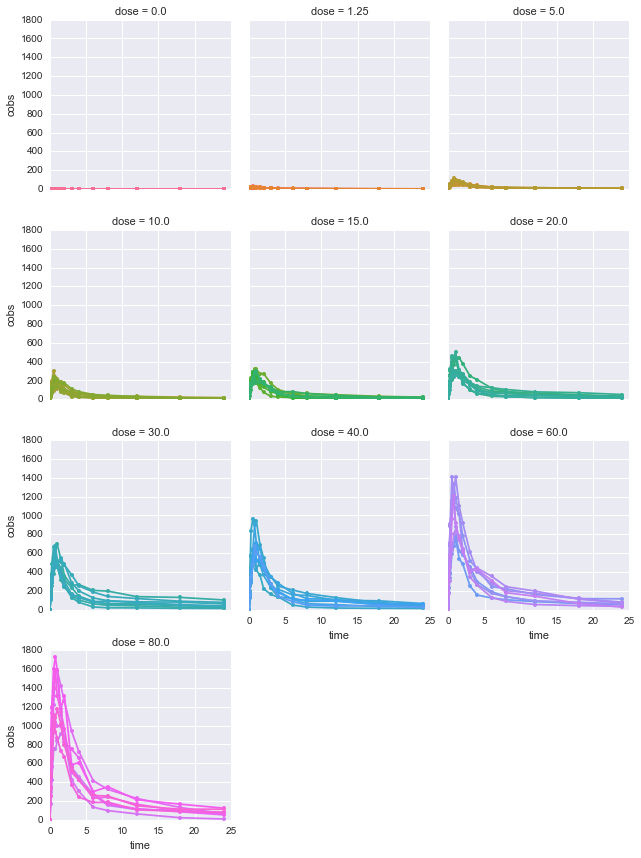

In [6]:
plasma = sns.FacetGrid(data, col="dose", hue="subject", col_wrap=3, size=3)
plasma.map(plt.plot, "time", "cobs", marker="o", ms=4)


### Plot fxa inhibition

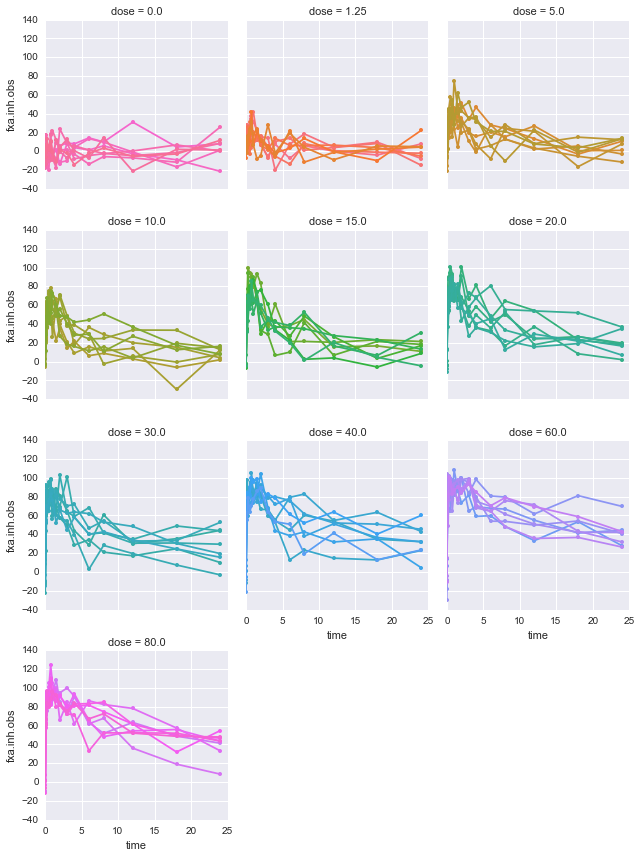

In [7]:
effects = sns.FacetGrid(data, col="dose",hue ="subject" ,col_wrap=3, size=3)
effects.map(plt.plot, "time", "fxa.inh.obs", marker="o", ms=4)

### Plot relationship over group

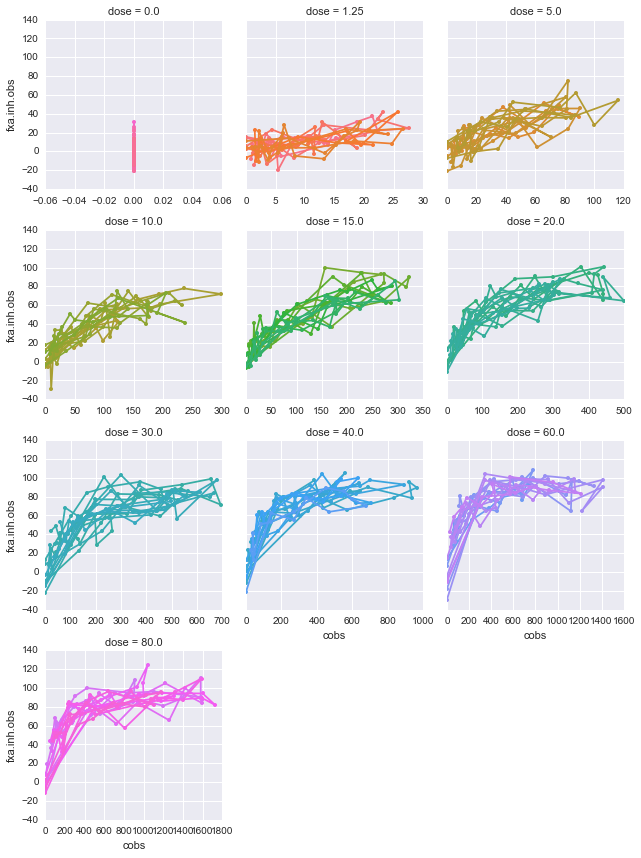

In [8]:
relationship = sns.FacetGrid(data, col="dose",hue ="subject" ,col_wrap=3, size=3, sharex=False)
relationship.map(plt.plot, "cobs", "fxa.inh.obs", marker="o", ms=4)

### Plot mean relationship

In [9]:
mean_df = data[['cobs', 'fxa.inh.obs']].groupby(data['subject']).mean()

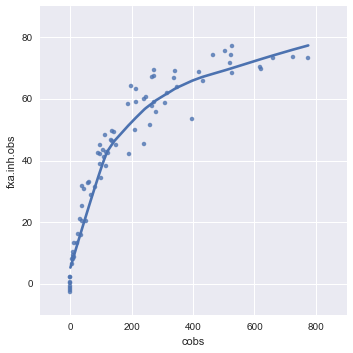

In [10]:
sns.lmplot(x="cobs", y="fxa.inh.obs", data=mean_df, lowess=True)

I have used the lowess function as a simple function to roughly plot the relation ship between mean drug plasma concentration 'cobs' and the fxa biomarker.

### Create the model

Now we will create the model, with fairly uninformative priors. Notice how I have also created a dummy variable called fxa_pred. This will create len(cobs) = 80 traces which we will use later as one of the different methods to assess the fit of the model.

We are fitting a simple eMax model to the data.

In [439]:
pkpd_model = Model()

with pkpd_model:

    # Priors for unknown model parameters
    emax = Uniform ('emax', lower =0, upper =100)
    ec50 = Lognormal('ec50', mu=0.01, tau = 5)
    gamma = Uniform('gamma', lower=0, upper =10)
    sigma = Uniform('sigma', lower = 0, upper = 1000 )
    
    
    # Expected value of outcome
    fxaMean = (emax*(cobs**gamma)) / ((ec50**gamma) + (cobs**gamma))

    # Likelihood (sampling distribution) of observations
    fxa = Normal('fxa', mu=fxaMean, sd=sigma, observed=fxa_in )
    # Dummy fxa variable that will hold the model predictions for each value of cobs
    fxa_pred = Normal('fxa_pred', mu=fxaMean, sd=sigma , shape =len(cobs))


Applied interval-transform to emax and added transformed emax_interval to model.
Applied log-transform to ec50 and added transformed ec50_log to model.
Applied interval-transform to gamma and added transformed gamma_interval to model.
Applied interval-transform to sigma and added transformed sigma_interval to model.


## Initate the MCMC

Firstly we find some reasonable starting values using find_MAP

Then we will take 2000 MCMC samples 

In [441]:
with pkpd_model:

    # obtain starting values via MAP
    start = find_MAP(fmin=scipy.optimize.fmin_powell)
    
    # draw 2000 posterior samples
    trace = sample(2000,  start=start) 

Assigned NUTS to emax_interval
Assigned NUTS to ec50_log
Assigned NUTS to gamma_interval
Assigned NUTS to sigma_interval
Assigned NUTS to fxa_pred
 [-----------------100%-----------------] 2000 of 2000 complete in 6.9 sec

### Lets take a look at the traces and see if they are reasonable

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123347210>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1239c2290>]], dtype=object)

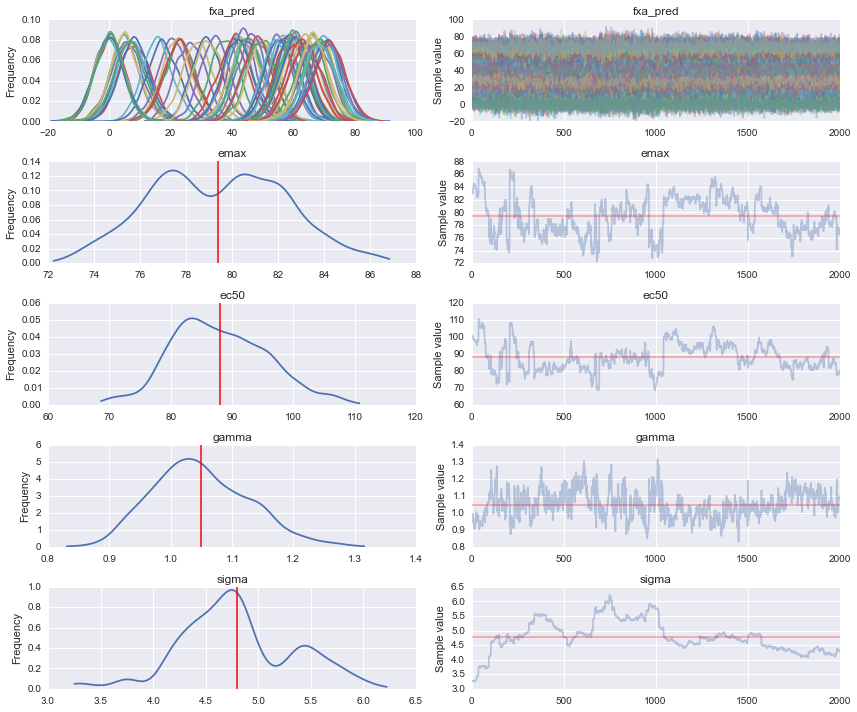

In [118]:
traceplot(trace, lines={k: v['mean'] for k, v in df_summary(trace).iterrows()})

# Lets evaluate our model fit against our observed fxa values... but how?

There are a number of ways to evaluate model fit. We will begin with the easiest...

First lets convert our traces to a dataframe for ease of use

In [443]:
t_df = trace_to_dataframe(trace)

In [444]:
t_df.head()

,ec50_log,emax_interval,ec50,emax,gamma_interval,sigma_interval,fxa_pred__0,fxa_pred__1,fxa_pred__2,fxa_pred__3,...,fxa_pred__72,fxa_pred__73,fxa_pred__74,fxa_pred__75,fxa_pred__76,fxa_pred__77,fxa_pred__78,fxa_pred__79,sigma,gamma
0,4.608540,1.610447,100.337599,83.347344,-2.216826,-5.719345,7.404983,5.313629,8.511735,6.004847,...,-1.912821e-10,-1.912821e-10,-1.912821e-10,-1.912821e-10,-1.912821e-10,-1.912821e-10,-1.912821e-10,-1.912821e-10,3.271126,0.982496
1,4.608540,1.610447,100.337599,83.347344,-2.216826,-5.719345,7.404983,5.313629,8.511735,6.004847,...,-1.912821e-10,-1.912821e-10,-1.912821e-10,-1.912821e-10,-1.912821e-10,-1.912821e-10,-1.912821e-10,-1.912821e-10,3.271126,0.982496
2,4.608540,1.610447,100.337599,83.347344,-2.216826,-5.719345,7.404983,5.313629,8.511735,6.004847,...,-1.912821e-10,-1.912821e-10,-1.912821e-10,-1.912821e-10,-1.912821e-10,-1.912821e-10,-1.912821e-10,-1.912821e-10,3.271126,0.982496
3,4.608325,1.606734,100.316027,83.295745,-2.225397,-5.719391,9.793733,4.564291,7.132367,5.142218,...,-2.401500e+00,-1.472834e+00,1.696248e+00,-1.429872e+00,1.857809e-01,-2.451912e+00,1.318011e-01,2.270975e+00,3.270975,0.974929
4,4.606848,1.611096,100.167933,83.356351,-2.219767,-5.719884,4.144692,4.230376,10.153133,8.021839,...,-1.659141e+00,-6.267387e-02,-4.221353e+00,1.212751e+00,1.414612e+00,4.726985e+00,-2.364176e+00,-1.348166e+00,3.269367,0.979894


## Method 1: recreate the model with the mean parameters from the traces and pass in a range of x values 

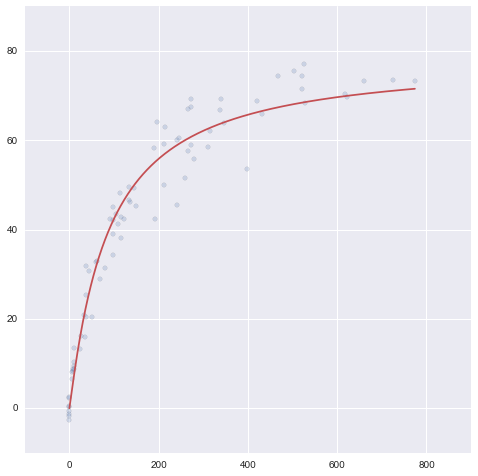

In [451]:
# Create a range of 'x' values to iterate over
i = np.array(range(int(min(cobs)),int(max(cobs)),1))

# Extract the mean values for the model parameter from the trace dataframe
g = t_df['gamma'].mean()
e50 = t_df['ec50'].mean()
em =  t_df['emax'].mean()

# recreate the 'y' values of fxa
y =  (em*(i**g)) / ((e50**g) + (i**g))

# Then plot everything
plt.figure(num=None, figsize=(8, 8),  facecolor='w', edgecolor='k')
plt.scatter(cobs, fxa_in, alpha =0.2)
plt.plot(i, y ,'r')
  

This way is okay, but it doesnt really give any feel for the uncertainty we have for fxa.

You can add in the percentile values for each model parameter and then replot,  but these do not reflect the credible intervals for fxa.... Take a look at the next plot where this is done and you can see why...

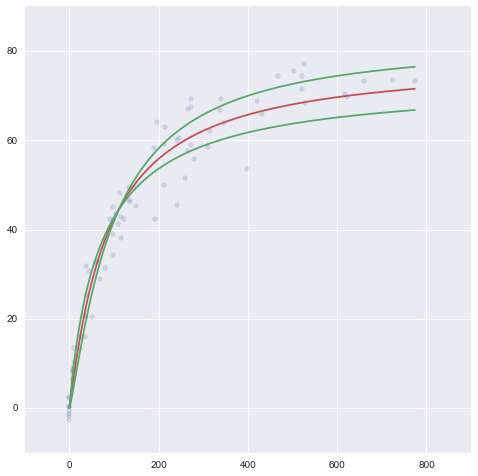

In [457]:
# Create a range of 'x' values to iterate over
i = np.array(range(int(min(cobs)),int(max(cobs)),1))

# Extract the mean values for the model parameter from the trace dataframe
g = t_df['gamma'].mean()
e50 = t_df['ec50'].mean()
em =  t_df['emax'].mean()

# recreate the 'y' values of fxa
y =  (em*(i**g)) / ((e50**g) + (i**g))

# Then plot everything
plt.figure(num=None, figsize=(8, 8),  facecolor='w', edgecolor='k')
plt.scatter(cobs, fxa_in, alpha =0.2)
plt.plot(i, y ,'r')
  

# Extract the quantile values for the model parameter from the trace dataframe
g = t_df['gamma'].quantile(q=0.05)
e50 = t_df['ec50'].quantile(q=0.05)
em =  t_df['emax'].quantile(q=0.055)

# recreate the 'y' values of fxa
y =  (em*(i**g)) / ((e50**g) + (i**g))

# Then plot the 5 quantile
plt.plot(i, y ,'g')
  
# Extract the quantile values for the model parameter from the trace dataframe
g = t_df['gamma'].quantile(q=0.95)
e50 = t_df['ec50'].quantile(q=0.95)
em =  t_df['emax'].quantile(q=0.95)

# recreate the 'y' values of fxa
y =  (em*(i**g)) / ((e50**g) + (i**g))

# Then plot the 95 quantile
plt.plot(i, y ,'g')



Notice how the quantile lines are not representative of the uncertainty in fxa. And certainly do not reflect a 90% credible interval.

what about plotting all the traces? we could try....

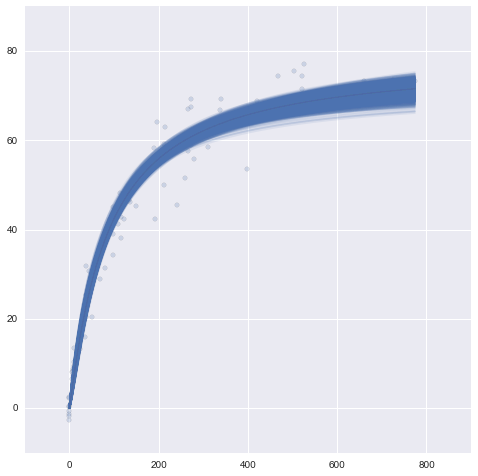

In [459]:
# Create a range of 'x' values to iterate over
i = np.array(range(int(min(cobs)),int(max(cobs)),1))

# Extract the mean values for the model parameter from the trace dataframe
g = t_df['gamma'].mean()
e50 = t_df['ec50'].mean()
em =  t_df['emax'].mean()

# recreate the 'y' values of fxa
y =  (em*(i**g)) / ((e50**g) + (i**g))

# Then plot everything
plt.figure(num=None, figsize=(8, 8),  facecolor='w', edgecolor='k')
plt.scatter(cobs, fxa_in, alpha =0.2)
plt.plot(i, y ,'r')

for  a,b in enumerate(trace) :
    g = trace[a]['gamma']
    e50 = trace[a]['ec50']
    em =  trace[a]['emax']
    y =  (em*(i**g)) / ((e50**g) + (i**g))
    plt.plot(i,y, 'b' ,alpha=0.1) 


Nope thats not working either! So how might we proceed?

## Method 2: Recreate the model and pass all the traces through it over a range of x values to  create a large matrix of possible credible values

This code is a modified version of a function I found on Jon Sedars excellent blog post about bayesian modelling found here...

http://blog.applied.ai/bayesian-inference-with-pymc3-part-1/

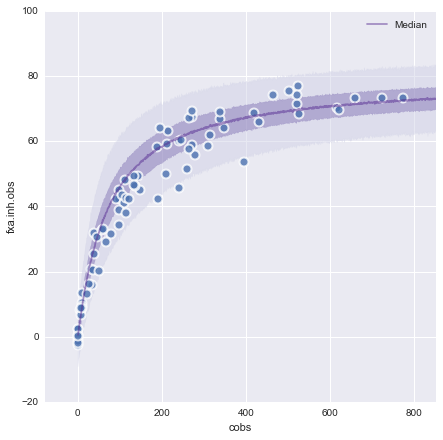

In [119]:
def plot_posterior_cr(mdl, trc, rawdata, xlims, npoints=1000):  
    '''
    Convenience fn: plot the posterior predictions from mdl given trcs
    '''
    x = np.linspace(xlims[0], xlims[1], 1000)
    
    ## extract traces
    trc_sd = trace_to_dataframe(trc)['sigma']   
    trc_gamma = np.array(trace_to_dataframe(trc)[['gamma']])
    trc_ec50 = np.array(trace_to_dataframe(trc)[['ec50']])
    trc_emax = np.array(trace_to_dataframe(trc)[['emax']])
 
    #recreate likelihood    
    cobs_gamma = x ** trc_gamma
    numerator =trc_emax*cobs_gamma
    denominator = np.add(cobs_gamma, (trc_ec50+trc_gamma))
    final = numerator/denominator
    like_mu = final.T
    
    # Expected value of outcome
    #fxaMean = (emax*(cobs**gamma)) / ((ec50**gamma) + (cobs**gamma))
    like_sd = np.tile(trc_sd.T,(npoints,1))
    like = np.random.normal(like_mu, like_sd)

    
    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(like,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Purples')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.4
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.5, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='cobs', y='fxa.inh.obs', data=rawdata, fit_reg=False
            ,scatter_kws={'alpha':0.8,'s':80, 'lw':2,'edgecolor':'w'}, ax=ax1d)

xlims = (mean_df['cobs'].min() - np.ptp(mean_df['cobs'])/10  
                 ,mean_df['cobs'].max() + np.ptp(mean_df['cobs'])/10)

plot_posterior_cr(pkpd_model, trace, mean_df, xlims)

This works well, and we get a great plot of credible values for fxa over a range of cobs, but it again relies upon recreating the model. Specifically the model need to be recreated in a form that is amendable for matrix calculations. This is possible if you are a numpy whizz, but not for me of only meager brain.

## Method 3: Utilising our dummy variable - remember fxa_pred? to evaluate the credible interval for fxa

We can use the values within the fxa_pred traces to evaluate the credible intervals and model fit for fxa without having to rebuild the model and iterate over it with a range of new x values as we did above.

Much simpler and less cumbersome/brainachey.

Lets pull out all the fxa_pred columns from the dataframe. Each column represents the traces obtained for the value of cobs that was passed in to the model. So the first fxa_pred column, "fxa_pred__0" contains 2000 estimates for fxa_pred for cobs with cobs [0] = 9.3812499999999961


So just examining the first element. This is the value of the plasma concentration passed in

In [460]:
cobs[0]

9.3812499999999961

This is the observed fxa value for that value of cobs

In [467]:
fxa_in[0]

10.352375000000002

This is the mean predicted value for fxa from the traces for that value of cobs...

In [465]:
t_df['fxa_pred__0'].mean()

6.594257945272233

So lets pull all the columns out and plot the predicted values for each cobs value and create a dataframe for plotting....

In [468]:
filter_col = [col for col in list(t_df) if col.startswith('fxa_pred')]

In [469]:
col= pd.DataFrame()
to_col =pd.DataFrame()
for n, cols in enumerate(filter_col):
        to_col['fxa_pred']=t_df[cols]
        to_col['cobs'] = cobs[n]
        col = pd.concat([col, to_col])

There is probably a much more elegant way of creating the dataframe for plotting!

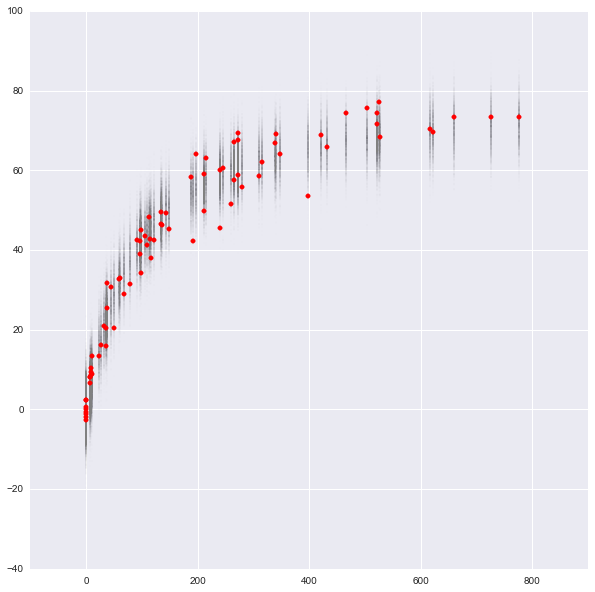

In [470]:
plt.figure(figsize=(10,10))
plt.scatter(col['cobs'], col['fxa_pred'], alpha =0.002, s= 15 ,color ='grey')
plt.scatter(cobs, fxa_in, alpha =1, color='red')

This looks pretty good, we get a feel for the credible intervals for the fxa_pred and we can sort of hack it to create a 90% credible interval...

In [336]:
col= np.empty([1,4])

for n, cols in enumerate(filter_col):
        a = cobs[n]
        b = t_df[cols].quantile(q=0.5)
        c = t_df[cols].quantile(q=0.95)
        d = t_df[cols].quantile(q=0.05)        
        e = np.array([a,b,c,d]).reshape(1,4)
        col = np.concatenate((col,e)) 
        
col = np.delete(col, (0), axis=0)
col = pd.DataFrame(col, columns=['cobs', 'mean', 'max', 'min'])
col = col.sort_index(by=['cobs'])

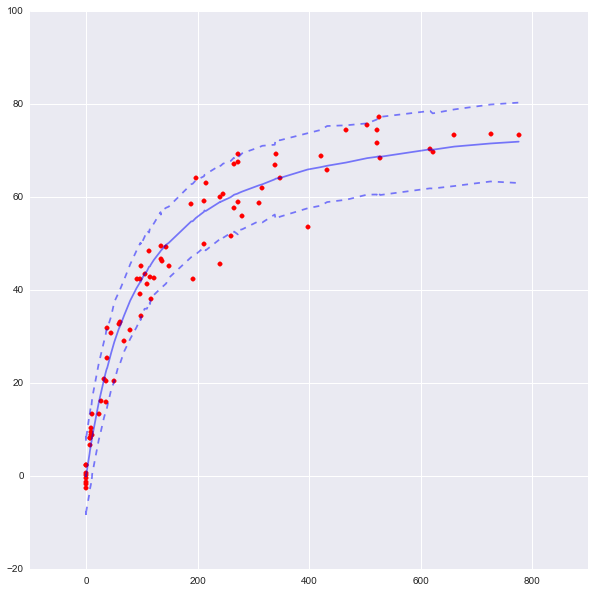

In [337]:
plt.figure(figsize=(10,10))
plt.plot(col['cobs'], col['mean'], '-', color = 'blue', alpha =0.5)
plt.plot(col['cobs'], col['max'], '--', color = 'blue', alpha =0.5)
plt.plot(col['cobs'], col['min'], '--',color = 'blue', alpha =0.5)
plt.scatter(cobs, fxa_in, alpha =1, color='red')

# How to make predictions from the model using new data

So the above was all very well, but its not completely satisfactory. What if we wanted to evaluate the range of responses that we might expect to see for a plasma concentration that hadnt already been observed?

Well thanks to a little poking around on stackoverflow I came across this post which answered thing perfectly...
http://stackoverflow.com/questions/33249122/generating-predictions-from-inferred-parameters-in-pymc3


The following is an implementation of the reply on the thread and it seems to work pretty nicely...

It utilises the concept of a theano shared variable, which in the first instance we pass in our cobs list, then when we want to create prediction we update the shared variable with the values we are interested in predicting.

## Make a shared variable for our independent variable

In [472]:
from theano import shared

In [473]:
cobs_shared = shared(cobs)

## recreate the model using shared variable

In [474]:
pkpd_model = Model()

with pkpd_model:

    # Priors for unknown model parameters
    emax = Uniform ('emax', lower =0, upper =100)
    ec50 = Lognormal('ec50', mu=0.01, tau = 5)
    gamma = Uniform('gamma', lower=0, upper =10)
    sigma = Uniform('sigma', lower = 0, upper = 1000 )
    
    
    # Expected value of outcome - note only change to the model is cobs_shared rather than cobs
    fxaMean = (emax*(cobs_shared**gamma)) / ((ec50**gamma) + (cobs_shared**gamma))

    # Likelihood (sampling distribution) of observations
    fxa = Normal('fxa', mu=fxaMean, sd=sigma, observed=fxa_in )


Applied interval-transform to emax and added transformed emax_interval to model.
Applied log-transform to ec50 and added transformed ec50_log to model.
Applied interval-transform to gamma and added transformed gamma_interval to model.
Applied interval-transform to sigma and added transformed sigma_interval to model.


In [475]:
with pkpd_model:

    # obtain starting values via MAP
    start = find_MAP(fmin=scipy.optimize.fmin_powell)
    
    # draw 2000 posterior samples
    trace = sample(2000,  start=start) 

Assigned NUTS to emax_interval
Assigned NUTS to ec50_log
Assigned NUTS to gamma_interval
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 2000 of 2000 complete in 5.9 sec

Now a little magic, lifted straight from the post

In [342]:
from collections import defaultdict

def run_ppc(trace, samples=100, model=None):
    """Generate Posterior Predictive samples from a model given a trace.
    """
    if model is None:
         model = pm.modelcontext(model)

    ppc = defaultdict(list)
    for idx in np.random.randint(0, len(trace), samples):
        param = trace[idx]
        for obs in model.observed_RVs:
            ppc[obs.name].append(obs.distribution.random(point=param))

    return ppc

Now lets make an array of cobs values we would like the fxa posterior for...

In [344]:
test_cobs =np.array([50,100,200,400,600])

set the shared variable with our test values...

In [345]:
cobs_shared.set_value(test_cobs)

call the run_ppc function....

In [347]:
ppc = run_ppc(trace, model=pkpd_model, samples=200)

This creates a dictionary with a list of arrays, we can split these out into a dataframe for understanding and manipulation easily...

In [383]:
ppc_df =pd.DataFrame(ppc['fxa'], columns = test_cobs)

In [385]:
ppc_df.head()

,50,100,200,400,600
0,19.406540,36.514348,60.328608,72.642597,67.183091
1,31.130266,46.286726,71.559167,71.282423,68.380982
2,30.838003,43.539296,59.866255,70.187913,66.139680
3,33.317584,42.509850,45.582081,57.014863,71.499895
4,22.381668,39.048707,68.885153,60.143690,69.795050


So here it is, we have all the values that we require for our dependent variable fxa for the values of cobs we passed in

In [387]:
ppc_df.describe()

,50,100,200,400,600
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,27.859306,42.453340,55.729234,65.249921,69.846227
std,4.955994,4.786758,5.011921,4.843295,5.201061
min,16.689981,30.390392,43.209117,51.008871,54.313142
25%,24.170868,39.030064,52.745129,62.078938,66.722240
50%,28.140138,42.171571,55.327374,65.389217,70.039765
75%,30.854404,46.174714,58.742674,68.211710,73.187622
max,43.501045,53.874741,71.559167,80.179937,86.677635


And we can have crazy fun in seaborn looking at the distributions...

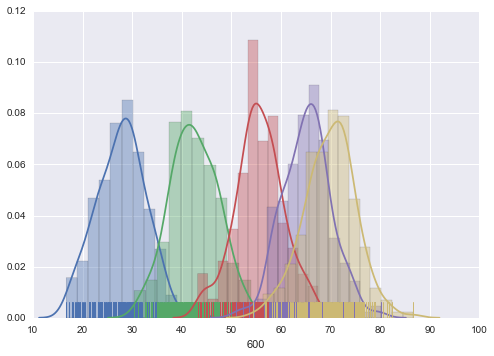

In [399]:
for c in ppc_df.columns:
    sns.distplot(ppc_df[c], rug =True)

or...

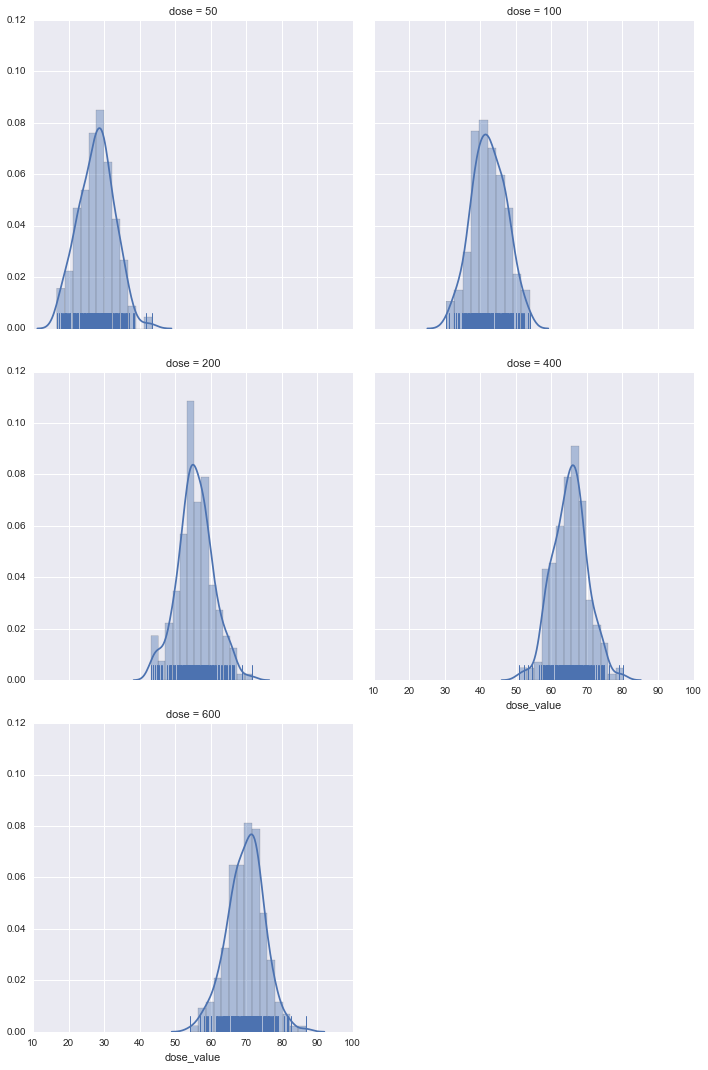

In [425]:
unstacked = pd.DataFrame(ppc_df.unstack()).reset_index()
unstacked.columns = ['dose', 'dose_index', 'dose_value']
g = sns.FacetGrid(unstacked, col = 'dose', col_wrap=2, size=5)
g = g.map(sns.distplot, "dose_value", rug=True)


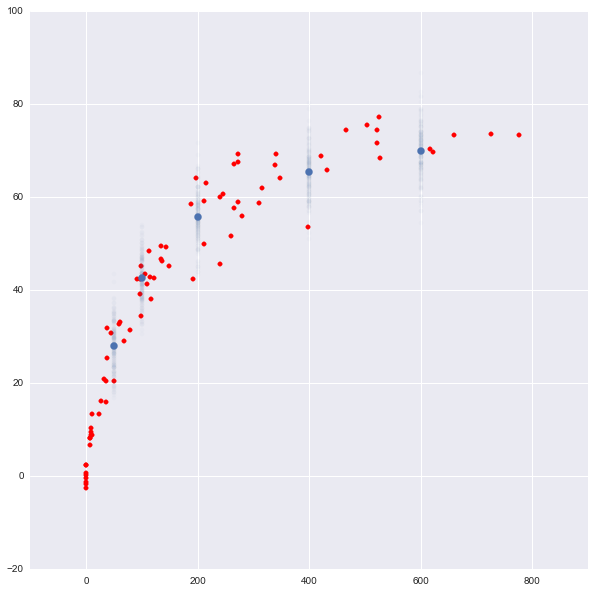

In [438]:
plt.figure(figsize=(10,10))
plt.scatter(cobs, fxa_in, alpha =1, color='red')
plt.scatter(unstacked['dose'], unstacked['dose_value'], alpha =0.02)
for c in ppc_df.columns:
    plt.scatter(c, ppc_df[c].mean(), color= 'b',s =50)